In [1]:
# Standard library imports
from argparse import ArgumentParser
import os, sys
THIS_DIR = os.path.abspath('')
PARENT_DIR = os.path.dirname(os.path.abspath(''))
sys.path.append(PARENT_DIR)

# Third party imports
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from torchdiffeq import odeint
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import imageio

# local application imports
from lag_caVAE.lag import Lag_Net
from lag_caVAE.nn_models import MLP_Encoder, MLP, MLP_Decoder, PSD
from hyperspherical_vae.distributions import VonMisesFisher
from hyperspherical_vae.distributions import HypersphericalUniform
from utils import arrange_data, from_pickle, my_collate, ImageDataset
from examples.pend_lag_cavae_trainer import Model as Model_lag_cavae
from ablations.ablation_pend_MLPdyna_cavae_trainer import Model as Model_MLPdyna_cavae
from ablations.ablation_pend_lag_vae_trainer import Model as Model_lag_vae
from ablations.ablation_pend_lag_caAE_trainer import Model as Model_lag_caAE
from ablations.HGN import Model as Model_HGN

seed_everything(0)
%matplotlib inline
DPI = 600

In [2]:
checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'pend-lag-cavae-T_p=4-epoch=701.ckpt')
model_lag_cavae = Model_lag_cavae.load_from_checkpoint(checkpoint_path)

checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'ablation-pend-MLPdyna-cavae-T_p=4-epoch=919.ckpt')
model_MLPdyna_cavae = Model_MLPdyna_cavae.load_from_checkpoint(checkpoint_path)

checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'ablation-pend-lag-vae-T_p=4-epoch=916.ckpt')
model_lag_vae = Model_lag_vae.load_from_checkpoint(checkpoint_path)

checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'ablation-pend-lag-caAE-T_p=4-epoch=778.ckpt')
model_lag_caAE = Model_lag_caAE.load_from_checkpoint(checkpoint_path)

checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'baseline-pend-HGN-T_p=4-epoch=1543.ckpt')
model_HGN = Model_HGN.load_from_checkpoint(checkpoint_path)

In [3]:
# Load data, prepare for plotting prediction
data_path=os.path.join(PARENT_DIR, 'datasets', 'pendulum-gym-image-dataset-test.pkl')
test_dataset = ImageDataset(data_path, 19, ctrl=False)
# select a particular trajectory
# batch_idx = 44
batch_idx = 2

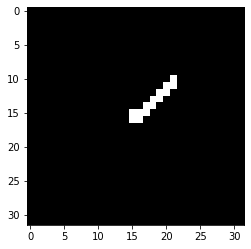

In [4]:
# plot the initial configuration
plt.imshow(test_dataset.x[0, batch_idx], cmap='gray')

/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


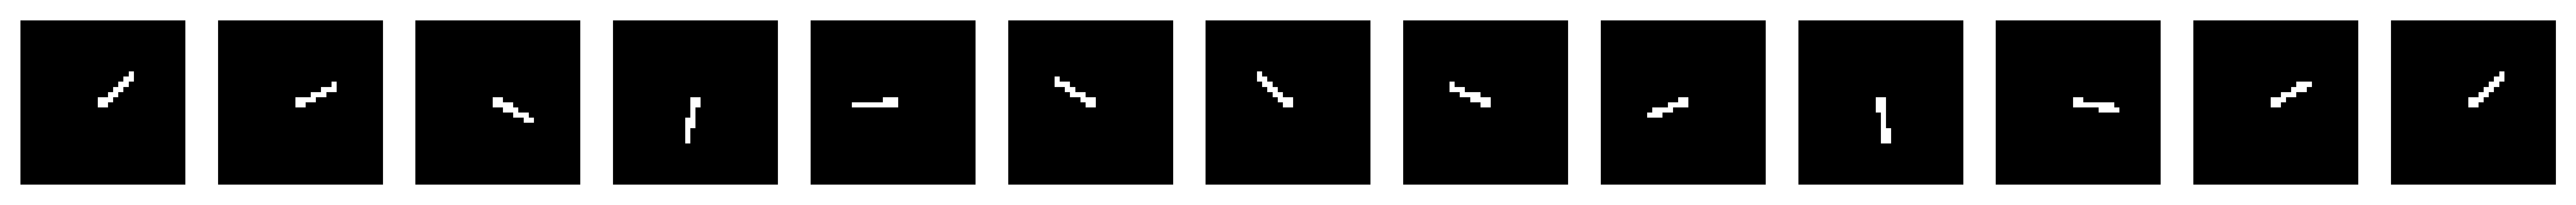

In [5]:
# plot true sequence
cos_q0, sin_q0 = test_dataset.obs[0, batch_idx, 0], test_dataset.obs[0, batch_idx, 1]
q_dot0 = test_dataset.obs[0, batch_idx, 2]
q0 = np.arctan2(sin_q0, cos_q0)
import gym, myenv
from skimage import color
env = gym.make('MyPendulum-v0')
env.reset()
env.state = np.array([q0, q_dot0], dtype=np.float32)
frame = color.rgb2gray(env.render(mode='rgb_array'))
frames = [frame]

for i in range(59):
    env.step([0])
    frame = color.rgb2gray(env.render(mode='rgb_array'))
    frames.append(frame)
env.close()

fig = plt.figure(figsize=(16, 4), dpi=DPI)
for i in range(13):
    plt.subplot(1, 13, i+1)
    plt.imshow(frames[i*4], cmap='gray')
    plt.axis('off')
# fig.savefig(os.path.join(PARENT_DIR, 'figures', f'true_pend_seq.png'), bbox_inches='tight')

In [6]:
# imageio.mimsave(os.path.join(PARENT_DIR, 'figures', 'true_pend_seq.gif'), (np.array(frames).clip(min=0, max=1)*255).astype(np.uint8), duration=0.05)

In [7]:
# prepare plotting prediction sequence
X = torch.tensor(test_dataset.x[0:2, batch_idx], dtype=torch.float32).view(2, 1, 32, 32)
u = torch.tensor([0.0], dtype=torch.float32).view(1,1)

timesteps = 60
t_eval = np.linspace(0, timesteps-1, timesteps) * 0.05
t_eval = torch.tensor(t_eval, dtype=torch.float32)

def plot_prediction(model, name, solver='rk4'):
    model = model_lag_cavae
    model.t_eval = t_eval
    model.hparams.solver = solver
    model.hparams.annealing = False
    model(X, u)
    fig = plt.figure(figsize=(16, 4), dpi=DPI)
    for i in range(13):
        plt.subplot(1, 13, i+1)
        plt.imshow(model.Xrec[i*4, 0].detach().cpu().numpy(), cmap='gray')
        plt.axis('off')
#     fig.savefig(os.path.join(PARENT_DIR, 'figures', f'prediction_pend_{name}.png'), bbox_inches='tight')
#     imageio.mimsave(os.path.join(PARENT_DIR, 'figures', f'prediction_pend_{name}.gif'), 
#                     (model.Xrec[:,0].detach().cpu().numpy().clip(min=0, max=1)*255).astype(np.uint8), 
#                     duration=0.05)

/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


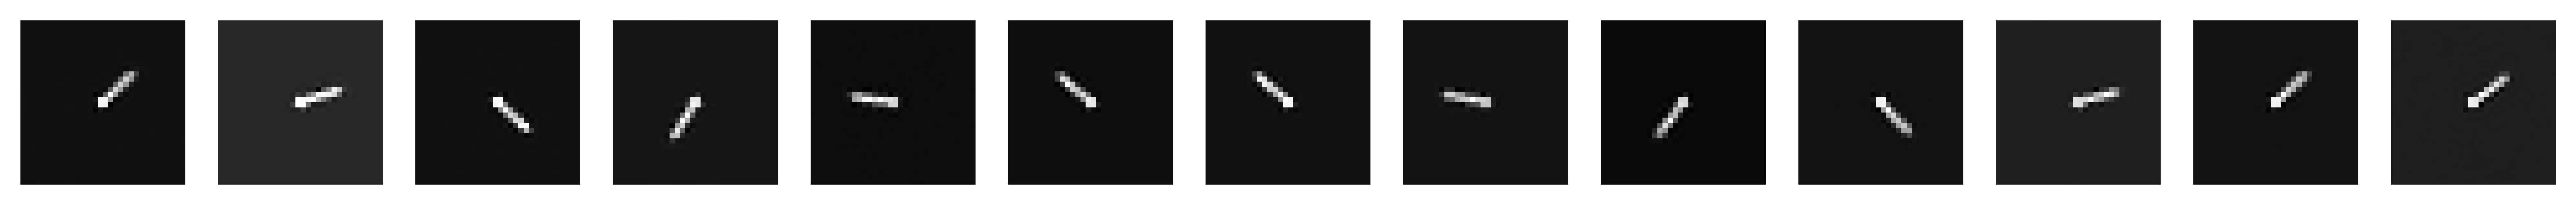

In [8]:
plot_prediction(model_lag_cavae, 'lag_cavae')

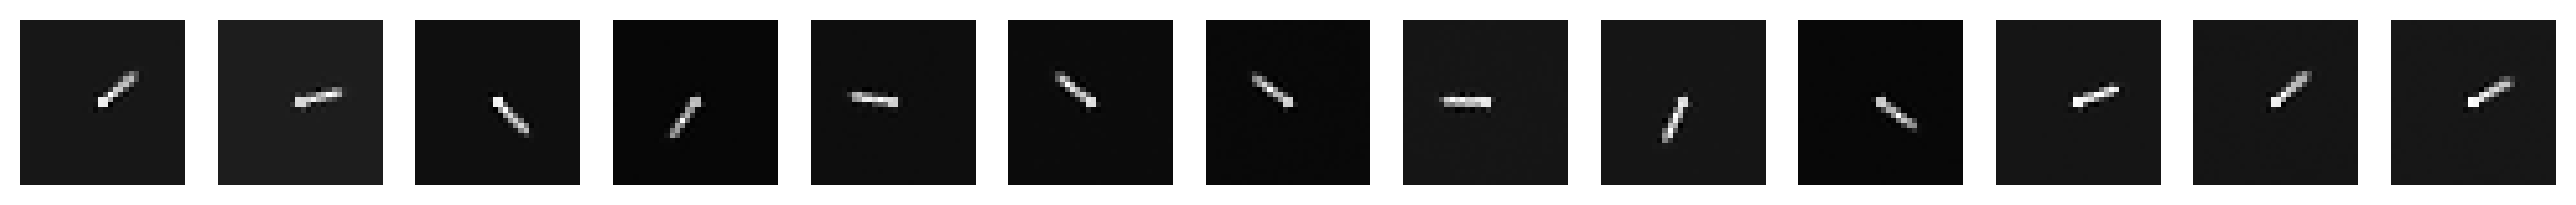

In [9]:
plot_prediction(model_MLPdyna_cavae, 'MLPdyna_cavae')

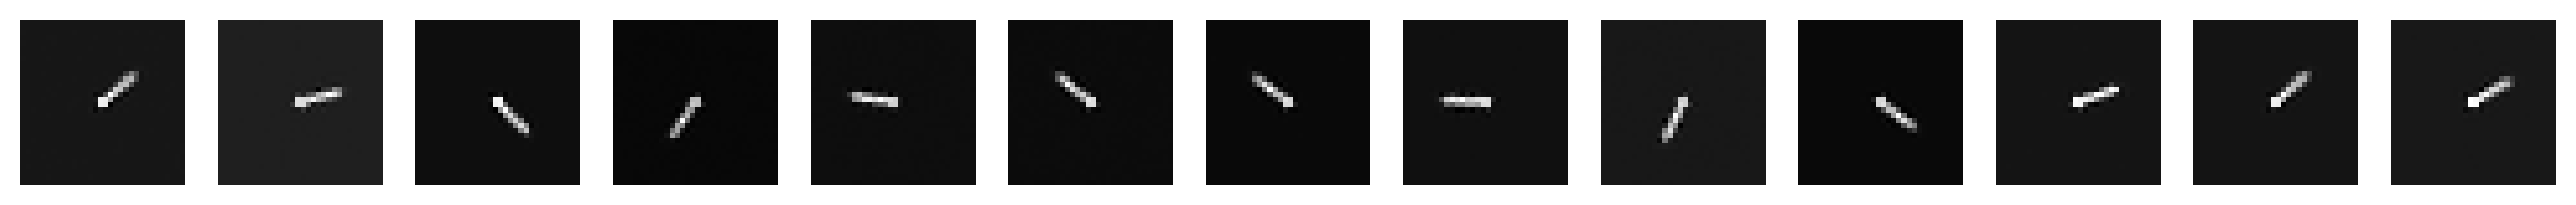

In [10]:
plot_prediction(model_lag_vae, 'lag_vae')

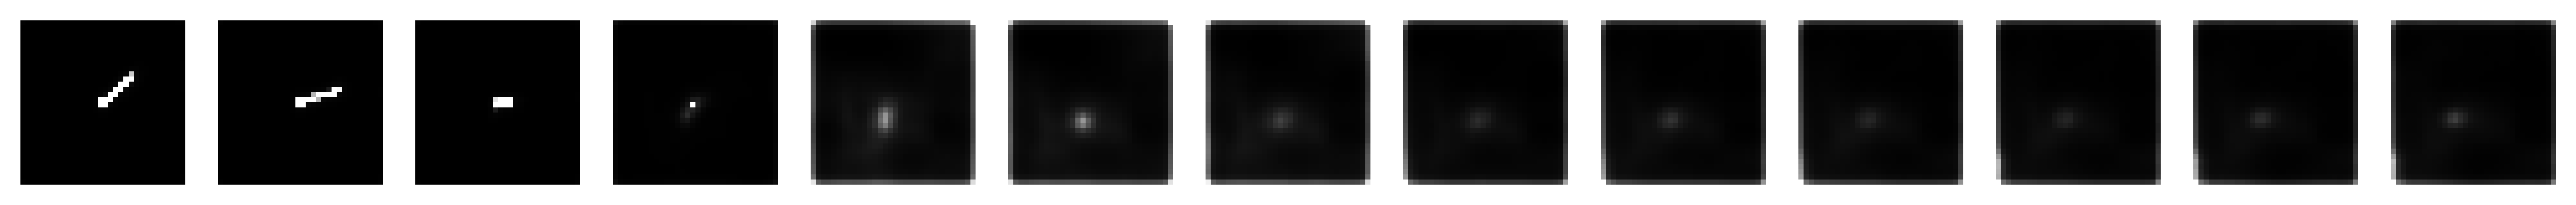

In [11]:
X = torch.tensor(test_dataset.x[0:5, batch_idx], dtype=torch.float32).view(5, 1, 32, 32)
X = X.view(X.shape[0], X.shape[1], 1, X.shape[2], X.shape[3])

model = model_HGN ; solver = 'rk4' ; name = 'HGN'
model.step = 3 ; model.alpha = 1
model.t_eval = t_eval
model.hparams.solver = solver
model(X[0:5])
fig = plt.figure(figsize=(16, 4), dpi=DPI)
for i in range(13):
    plt.subplot(1, 13, i+1)
    plt.imshow(model.Xrec[i*4, 0, 0].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
# fig.savefig(os.path.join(PARENT_DIR, 'figures', f'prediction_pend_{name}.png'), bbox_inches='tight')

In [12]:
# imageio.mimsave(os.path.join(PARENT_DIR, 'figures', 'prediction_pend_HGN.gif'), 
#                 (model.Xrec[:, 0, 0].detach().cpu().numpy().clip(max=1, min=0)*255).astype(np.uint8), 
#                 duration=0.05)